## Coursera Machine Learning for Data Analysis
### Week 1 Assignment

#### Intro
I decided to work with a famous dataset - the [Pima Indians Diabetes Database](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names), which gives you different parameters regarding Indian women's health and medical history, along with a label of having or not having diabetes.<br>
We'll run a decision tree analysis to see if we can predict having diabetes from the other indicators.<br>

In [1]:
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

import os

#Displaying the decision tree
from sklearn import tree
from io import BytesIO as StringIO
from IPython.display import Image
out = StringIO()
import pydotplus

In [2]:
# Pima Indian Diabetes dataset from the UCI Machine Learning Repository

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names)

print pima.shape

pima.head()

(768, 9)


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here is the codebook for the labels, by order of appearance - left to right:<br>
(copied directly from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.names))
1. Number of times pregnant
+ Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ Diastolic blood pressure (mm Hg)
+ Triceps skin fold thickness (mm)
+ 2-Hour serum insulin (mu U/ml)
+ Body mass index (weight in kg/(height in m)^2)
+ Diabetes pedigree function
+ Age (years)
+ Class variable (0 or 1)


In [3]:
# let's check there are no missing values we need to handle

pima.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnant    768 non-null int64
glucose     768 non-null int64
bp          768 non-null int64
skin        768 non-null int64
insulin     768 non-null int64
bmi         768 non-null float64
pedigree    768 non-null float64
age         768 non-null int64
label       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [4]:
# we can see that for all of the women in the study there are no null values for either parameter. Hooray!

In [5]:
# Some descriptive statistics:

pima.describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# And now we'll look at how prevalent diabetes is at the first place.
# This will be useful to examine how well our model is doing.

pima['label'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: label, dtype: float64

We can see that 65% of women do not have diabetes.<br>
What this means is that if we always 'predict' 0 - no diabetes - our prediction would be right **65%** of the time. So, this is **the baseline to beat**.

** Let's do it! **

In [7]:
# Split to Target and Features
y = pima['label']

# Since 'label' is the last column on the right, we can easily create a list of features like so:
features = col_names[:-1]       # alternatively: list(pima.columns[:-1])
print features

# and use that to get the features DataFrame
X = pima.loc[:, features]
X.head()

['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age']


,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [8]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

print 'There are %d rows and %d columns in the training set.' % (X_train.shape[0], X_train.shape[1])
print 'There are %d rows and %d columns in the test set.' % (X_test.shape[0], X_test.shape[1])
print 'There are %d targets in the training set.' % y_train.shape[0]
print 'There are %d targets in the test set.' % y_test.shape[0]

There are 460 rows and 8 columns in the training set.
There are 308 rows and 8 columns in the test set.
There are 460 targets in the training set.
There are 308 targets in the test set.


In [9]:
# Instantiate the model
model = DecisionTreeClassifier(criterion='gini') # we'll start with 'gini' and maybe compare to information gain later.

# fit the model with the training data
model.fit(X_train, y_train)

# and make predictions on the test data
y_pred = model.predict(X_test)

# let's check our accuracy
sklearn.metrics.accuracy_score(y_test, y_pred)

0.72402597402597402

We see our accuracy (albeit based on one run) is better than the baseline, which is good! <br>
We'll try to improve on it and also have more robus results.

In [10]:
# print the confusion metrics:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[166,  39],
       [ 46,  57]])

In [11]:
print sklearn.metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.78      0.81      0.80       205
          1       0.59      0.55      0.57       103

avg / total       0.72      0.72      0.72       308



We see in the classification report that we're doing better at predicting 0 (no diabetes) than 1.

In [12]:
# Let's print the feature importance

for i in range(len(features)):
    print features[i], '    |    ', model.feature_importances_[i]

pregnant     |     0.0436552653466
glucose     |     0.298072264975
bp     |     0.0699861264114
skin     |     0.0194460906325
insulin     |     0.048484909387
bmi     |     0.214490109533
pedigree     |     0.155479138812
age     |     0.150386094903


It's not surprising to see 'gluose' is the most important feature in predicting diabetes. 'Pregnant' and 'skin' are the least important.

In [13]:
# Before we visualize the tree, let's see how many nodes (including terminal leaves) there are in the tree:

model.tree_.node_count

169

There are 169 nodes, which would make visualiztion hard to follow.<br>
Let's see if we can get similar accuracy - or even better - with fewer nodes.

In [14]:
# First, let's establish what our accuracy score looks like.
# We'll run the classifier multiple times and average the results, to get a more robust estimate of how well it's
# doing. For that, let's write a function with the different steps, and loop through it multiple times.


def run_decision_tree_clf(X, y, test_size, criterion, max_depth, min_samples_split):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return sklearn.metrics.accuracy_score(y_test, y_pred)

scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X, y, test_size=0.4, criterion='gini', max_depth=None, min_samples_split=1))
    
pd.Series(scores).describe()

count    200.000000
mean       0.695130
std        0.024178
min        0.636364
25%        0.678571
50%        0.694805
75%        0.711039
max        0.756494
dtype: float64

In [15]:
# We see the mean score is just about 0.7, which is fairly close to what we god before.
# Can we do better with 'information gain' instead?

scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X, y, test_size=0.4, criterion='entropy', max_depth=None, min_samples_split=1))
    
pd.Series(scores).describe()

count    200.000000
mean       0.697581
std        0.024687
min        0.633117
25%        0.678571
50%        0.698052
75%        0.714286
max        0.753247
dtype: float64

We see using information gain / entropy as the criterion for the classifier doesn't do any better, so we'll continue with gini.

In [16]:
# Now, let's try to see if we can make the tree smaller without losing (and perhaps with gaining) model accuracy.

# first, let's try reducing the number of features to simplify the tree and see what happens.
# let's run the feature_importances_ method several times to get robust results.
# for that, we'll need to modify our function just a little.

def run_decision_tree_clf1(X, y, test_size, criterion, max_depth, min_samples_split):  # notice function's name
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.feature_importances_   # <---  what has changed



feature_importance = []

for i in range(200):
    feature_importance.append(run_decision_tree_clf1(X, y, test_size=0.4, criterion='gini', 
                                                          max_depth=None, min_samples_split=1))
    
pd.DataFrame(feature_importance, columns=features).mean()

pregnant    0.066154
glucose     0.318207
bp          0.087056
skin        0.051598
insulin     0.053796
bmi         0.175340
pedigree    0.124995
age         0.122854
dtype: float64

In [17]:
# We see that over 200 runs, skin, insuling and pregnant were the least important features, in that order.
# What will happen if we remove them?

features1 = ['glucose', 'bp', 'bmi', 'pedigree', 'age']

X1 = pima.loc[:, features1]

scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X1, y, test_size=0.4, criterion='gini', max_depth=None, min_samples_split=1))
    
pd.Series(scores).describe()

count    200.000000
mean       0.695633
std        0.027082
min        0.616883
25%        0.675325
50%        0.694805
75%        0.714286
max        0.766234
dtype: float64

In [18]:
# We didn't do any worse with fewer features, so let's stick with those features, just to make the tree more compact.

# Let's try to change different parameters and see if we can improve the accuracy just by keeping the tree smaller 
# (fighting overfitting)

# We'll start with the minimum number of sample to split

scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X1, y, test_size=0.4, criterion='gini', max_depth=None, min_samples_split=100))
    
pd.Series(scores).describe()

count    200.000000
mean       0.741153
std        0.023566
min        0.681818
25%        0.724026
50%        0.743506
75%        0.759740
max        0.785714
dtype: float64

In [19]:
# We are now doing a lot better! We gained about 4% in accuracy! Let's try a few more values to min_samples_split.

scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X1, y, test_size=0.4, criterion='gini', max_depth=None, min_samples_split=50))
    
pd.Series(scores).describe()

count    200.000000
mean       0.735438
std        0.024224
min        0.649351
25%        0.717532
50%        0.737013
75%        0.753247
max        0.795455
dtype: float64

In [20]:
scores = []
for i in range(200):
    scores.append(run_decision_tree_clf(X1, y, test_size=0.4, criterion='gini', max_depth=None, min_samples_split=150))
    
pd.Series(scores).describe()

count    200.000000
mean       0.737062
std        0.026924
min        0.649351
25%        0.720779
50%        0.737013
75%        0.756494
max        0.801948
dtype: float64

Looks like a good value for min_samples_split is 100 samples! Nice.<br>
Let's see how many nodes we have now (earlier we had 169).

In [21]:
def run_decision_tree_clf2(X, y, test_size, criterion, max_depth, min_samples_split):  # notice function's name
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.tree_.node_count   # <---  what has changed



num_nodes = []

for i in range(200):
    num_nodes.append(run_decision_tree_clf2(X1, y, test_size=0.4, criterion='gini', 
                                                          max_depth=None, min_samples_split=100))
    
pd.Series(num_nodes).mean()

16.210000000000001

We see we get better accuracy than before, with about 10% of the nodes! Awesome square!

In [22]:
# Finally, let's experiment with the max_depth parameter.


scores = {}
for i in range(2, 16):
    accuracy = []
    for j in range(200):
        accuracy.append(run_decision_tree_clf(X1, y, test_size=0.4, criterion='gini', 
                                              max_depth=i, min_samples_split=100))
    mean_accuracy = pd.Series(accuracy).mean()
    scores[i] = mean_accuracy

scores

{2: 0.73850649350649344,
 3: 0.73321428571428582,
 4: 0.74355519480519494,
 5: 0.74212662337662338,
 6: 0.74529220779220784,
 7: 0.7427435064935064,
 8: 0.74779220779220779,
 9: 0.74452922077922079,
 10: 0.74275974025974023,
 11: 0.74452922077922079,
 12: 0.74042207792207793,
 13: 0.74056818181818185,
 14: 0.74715909090909094,
 15: 0.74056818181818185}

Well, it doesn't look like there's a lot of difference when we change max_depth. It's likely b/c the min_samples_split is taking over. When I ran it withat any restrictions on the split, I got results lower than 74%, so let's keep the min_samples_split and take max_depth of 8.

In [23]:
# Finally, let's run the model one more time and visualize a tree, per the task's instructions.

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.4)
model = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
sklearn.metrics.accuracy_score(y_test, y_pred)

0.73376623376623373

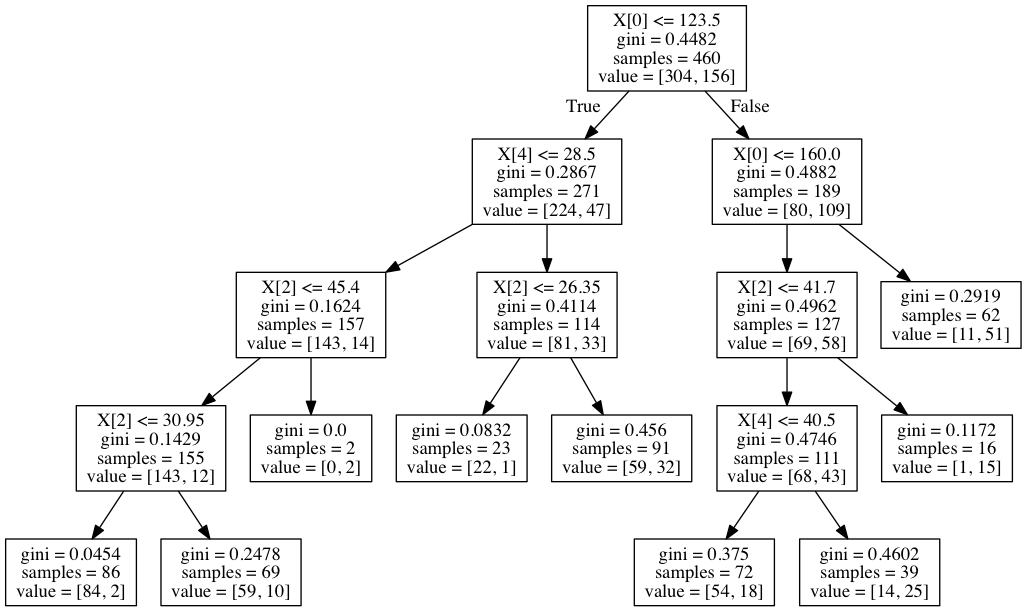

In [24]:
# Let's visualize the tree

out = StringIO()
tree.export_graphviz(model, out_file=out)

graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

In [46]:
for i in range(len(features1)):
    print i, '  |  ', features1[i], '      |   ', model.feature_importances_[i]

0   |   glucose       |    0.616402205126
1   |   bp       |    0.0
2   |   bmi       |    0.213986321773
3   |   pedigree       |    0.0
4   |   age       |    0.169611473101


We can see the classifier only used 3 features (in order of importance): glucose, bmi and age.

In [47]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.73376623376623373

In [27]:
sklearn.metrics.confusion_matrix(y_test, y_pred)

array([[173,  23],
       [ 59,  53]])

In [34]:
print sklearn.metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.75      0.88      0.81       196
          1       0.70      0.47      0.56       112

avg / total       0.73      0.73      0.72       308



There are two things that are evident from the confusion matrix and the classification report:
1. When the subject doesn't have diabetes, the model does a pretty good job at predicting it (precision, meaning - when a value is predicted, how often is the prediction correct, is 0.75 and recall - meaning - when the actual value is X, how often is the prediction correct, is 0.88.<br>

+ Unfortunatelly recall is only 0.47 for the True class. This means that when the subject does have diabetes, our model would only predict that 47% of the time. Of the 112 subjects with diabetes in the test set, for only 53 the model predicted diabetes. This goes hand in hand with an f1 score of just 0.56.<br>

To sum up, the model does a pretty good job predicting there's no diabetes when there is none indeed (the more common case), but doesn't perform well predicting diabetes when the subject does have it.

----

### Thank you kind stranger for reading! :)